Data from [Richness and resilience in the Pacific: DNA metabarcoding
enables parallelized evaluation of biogeographic patterns](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/mec.16575)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from collections import Counter
from itertools import combinations
from scipy.stats import entropy

import sys
sys.path.append('/home/isaac/proj/IMEMEBA-BCI')
import BCI

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


# Preprocess the metadata and fasta data so the zotu names agree

Only need to run these cells the first time the data is loaded. Don't run them again or it messes the data.

In [2]:
tmp = "MEC_16575_Kennedy_SuppTable3_zOTUtable.csv"
data = open(tmp).readlines()
with open(tmp, 'w') as outfile:

    for line in data:
        if "archipelago" in line:
            dat = line.split(",")
            header = dat[:10]
            dat = ",".join(header + [x.lower().strip().strip("_") for x in dat if "OTU" in x])
            line = dat+"\n"
        outfile.write(line)

In [3]:
seq_data = open("HCO_MCO_zotus.fas").read().split()
with open("HCO_MCO_zotus.fas", 'w') as outfile:
    for line in seq_data:
        if ">" in line:
            line = line.lower().strip("_")
        outfile.write(line+"\n")

# Now load the metadata and parse it

In [8]:
# low_memory=False allows PD to correctly infer dtype for columns
# header=8 <- Lots of taxonomic metadata in rows 1-7 that we don't need
metadata = pd.read_csv("MEC_16575_Kennedy_SuppTable3_zOTUtable.csv", low_memory=False, header=8)

# Exclude MCO as the shorter fragment. The alternative is to merge MCO/HCO but this feels annoying
metadata = metadata[metadata["marker"] == "HCO"]

# Exclude 'April' samples as these were used for callibrating sampling and were removed by
# Kennedy et al
metadata = metadata[metadata["season"] != "April"]
metadata

,archipelago,forest_type,site,transect,season,side,collection_method,marker,plate_well,sample_UID,zotu1_otu1,zotu714_otu1,zotu1367_otu1,zotu1785_otu1,zotu3468_otu1,zotu3885_otu1,zotu7361_otu1,zotu2_otu2,zotu3162_otu2,zotu4054_otu2,zotu9012_otu2,zotu3_otu3,zotu4_otu4,zotu5_otu5,zotu6_otu6,zotu7_otu7,zotu58_otu7,zotu107_otu7,zotu488_otu7,zotu766_otu7,zotu1115_otu7,zotu1497_otu7,zotu1509_otu7,zotu1672_otu7,zotu2524_otu7,zotu2574_otu7,zotu2664_otu7,zotu3840_otu7,zotu4565_otu7,zotu4876_otu7,zotu5837_otu7,zotu6198_otu7,zotu6850_otu7,zotu8518_otu7,zotu8_otu8,zotu1042_otu8,zotu2214_otu8,zotu2643_otu8,zotu2935_otu8,zotu5513_otu8,...,zotu7416_otu4248,zotu7429_otu4256,zotu7434_otu4258,zotu7456_otu4269,zotu7461_otu4272,zotu7479_otu4284,zotu2931_otu4286,zotu5011_otu4286,zotu7481_otu4286,zotu7482_otu4287,zotu7485_otu4288,zotu7489_otu4290,zotu7497_otu4295,zotu7498_otu4296,zotu7572_otu4344,zotu7573_otu4345,zotu1731_otu4349,zotu7597_otu4356,zotu7607_otu4361,zotu7635_otu4376,zotu7639_otu4378,zotu7640_otu4379,zotu7652_otu4388,zotu7654_otu4389,zotu7660_otu4392,zotu7674_otu4399,zotu7679_otu4402,zotu7683_otu4404,zotu7687_otu4407,zotu7692_otu4411,zotu7705_otu4419,zotu7707_otu4420,zotu7722_otu4430,zotu6473_otu4431,zotu7648_otu4431,zotu7723_otu4431,zotu8584_otu4431,zotu7745_otu4445,zotu6684_otu4449,zotu7750_otu4449,zotu767_otu4454,zotu7764_otu4458,zotu7771_otu4462,zotu7772_otu4463,zotu7779_otu4466,zotu7787_otu4470,zotu7788_otu4471,zotu8761_otu4471,zotu7826_otu4483,zotu7831_otu4486
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HCO,KM1_01A,KM1_neg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,Ryukyus,intact,R09,R09A,October,NaN,beating,HCO,KM1_04A,R09AV06,0,0,0,0,0,0,0,0,0,0,0,0,0,313,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,Ryukyus,intact,R09,R09A,October,NaN,beating,HCO,KM1_04B,R09AV07,4,0,0,0,0,0,0,0,0,0,0,0,0,638,0,87,548,0,54,25,8,16,6,0,10,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46,Ryukyus,intact,R09,R09B,October,NaN,beating,HCO,KM1_04C,R09BV06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48,Ryukyus,intact,R09,R09B,October,NaN,beating,HCO,KM1_04D,R09BV07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Marianas,intact,M03,M03C,NaN,NaN,beating,HCO,RPfirst_17,M03CV10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
820,Ryukyus,degraded,R14,R14C,October,NaN,beating,HCO,RPfirst_18,R14CV10,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
822,Hawaii,degraded,H03,H03B,NaN,leeward,beating,HCO,RPfirst_19,H03BV06,359,130,91,3,4,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1395,102,16,45,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
824,Ryukyus,degraded,R12,R12A,October,NaN,beating,HCO,RPsecond_01,R12AV09,0,0,0,0,0,

## Map zotus to site codes

In [9]:
zotus_per_site = {}
gb = metadata.groupby(['archipelago', 'forest_type', 'site'])
for site, samps in gb:
    # select only the zotu columns
    zotu_table = samps.filter(like="zotu")
    # Get all zotus that occur at least once in this site/transect
    zotu_presence = zotu_table.any(axis=0)
    # Retain all the zotu IDs that are present in this site/transect
    # Get the otus that are present, get the index then:
    # * Force lowercase for all zotu names so metadata agrees with fasta file
    # * Remove trailing underscores
    zotu_presence = zotu_presence[zotu_presence == True].index.values
    zotus_per_site["_".join(site)] = zotu_presence

for k, v in zotus_per_site.items():
    print(k, "\t", len(v))

Hawaii_degraded_H03 	 228
Hawaii_degraded_H04 	 387
Hawaii_degraded_H05 	 240
Hawaii_intact_H01 	 371
Hawaii_intact_H02 	 358
Hawaii_intact_H06 	 344
Marianas_degraded_M04 	 246
Marianas_degraded_M05 	 231
Marianas_degraded_M06 	 267
Marianas_intact_M01 	 307
Marianas_intact_M02 	 290
Marianas_intact_M03 	 325
Ryukyus_degraded_R10 	 465
Ryukyus_degraded_R12 	 420
Ryukyus_degraded_R13 	 511
Ryukyus_degraded_R14 	 490
Ryukyus_intact_R09 	 505
Ryukyus_intact_R11 	 520


## Make a dict mapping OTU names to sequences

In [10]:
seq_data = open("HCO_MCO_zotus.fas").read().split()
## Doing some formatting to make metadata and fasta zotu names agree:
# Drop the leading >
# Force all lowercase
# Remove trailing underscore
zotus = [x[1:] for x in seq_data[::2]]
# Strip trailing gaps (not sure why they are there)
fastas = [x.rstrip("-") for x in seq_data[1::2]]

#seq_df = {x:y for x,y in zip(zotus, fastas)}
seq_df = pd.Series(fastas, index=zotus)
seq_df

zotu1_otu1         TCTTTCGGCTGGAATCGCTCACGCCGGAGCTTCAGTAGATCTCTCA...
zotu2_otu2         ACTTTCATCTAATATTGCTCATGGTGGAAGTTCAGTAGATTTAGCG...
zotu3_otu3         TCTATCTGCAGCTGTAGCTCACGCAGGAGCTTCAGTAGATTTAGCA...
zotu4_otu4         ATTATCAAACAATACTTATCATAATGGCCCATCAGTAGATCTAGCC...
zotu5_otu5         CCTATCTTCAAATATTTATCATAATGGACCTTCAGTAGATTTAGCA...
                                         ...                        
zotu9187_otu301    TCTCTCAGCTAATATTGCTCATGCTGGAGCATCTGTAGATTTAGCT...
zotu9188           ATTATCAGGAATACAAAGCCACAGTGGTCCCAGTGTAGACCTAGCT...
zotu9189           ACTAGCGGCGAATATTGCTCATAGAGGAGCTTCAGTAGATATGGGG...
zotu9190_otu110    CCTTTCATCTAATATTGCTCATGCTGGTGCATCAGTTGATTTAGCA...
zotu9191           TTTATCTGGATTACAAAGTCACAGTGGACCTAGTGTTGATTTAGCT...
Length: 9191, dtype: object

## Make a new fasta file for all the sequences w/in a site

In [11]:
for site, zotus in zotus_per_site.items():
    fasta_data = seq_df.loc[zotus]
    # Check fasta files should be this length
    print(site, len(fasta_data)*2)
    with open(f"site_fastas/{site}.fasta", 'w') as outfile:
        for k, v in fasta_data.items():
            outfile.write(f">{k}\n{v}\n")

Hawaii_degraded_H03 456
Hawaii_degraded_H04 774
Hawaii_degraded_H05 480
Hawaii_intact_H01 742
Hawaii_intact_H02 716
Hawaii_intact_H06 688
Marianas_degraded_M04 492
Marianas_degraded_M05 462
Marianas_degraded_M06 534
Marianas_intact_M01 614
Marianas_intact_M02 580
Marianas_intact_M03 650
Ryukyus_degraded_R10 930
Ryukyus_degraded_R12 840
Ryukyus_degraded_R13 1022
Ryukyus_degraded_R14 980
Ryukyus_intact_R09 1010
Ryukyus_intact_R11 1040


## Run BCIs

In [12]:
fastas = sorted(glob.glob("site_fastas/*.fasta"))
bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    bcis[site] = BCI.BCI(data=fasta, verbose=True)
    bcis[site]._min_clust_threshold = 70
    bcis[site].run()

Hawaii_degraded_H03
[228, 178, 157, 143, 136, 133, 128, 125, 124, 122, 119, 114, 111, 106, 104, 101, 91, 86, 81, 75, 66, 56, 47, 41, 31, 27, 23, 18, 16, 13]
Hawaii_degraded_H04
[387, 276, 220, 196, 182, 170, 154, 141, 132, 125, 123, 118, 115, 105, 102, 99, 88, 85, 81, 71, 66, 58, 48, 39, 34, 27, 20, 17, 15, 11]
Hawaii_degraded_H05
[240, 182, 156, 143, 133, 129, 124, 122, 119, 113, 113, 113, 110, 109, 106, 105, 99, 88, 84, 77, 65, 57, 47, 41, 31, 28, 17, 16, 13, 12]
Hawaii_intact_H01
[371, 261, 206, 172, 162, 157, 142, 134, 123, 116, 112, 107, 101, 95, 95, 88, 83, 74, 65, 62, 53, 47, 39, 33, 26, 17, 16, 13, 10, 8]
Hawaii_intact_H02
[358, 258, 212, 189, 179, 174, 164, 157, 152, 145, 138, 131, 125, 118, 113, 106, 97, 86, 83, 77, 67, 60, 53, 39, 35, 28, 22, 16, 13, 12]
Hawaii_intact_H06
[344, 241, 190, 161, 151, 138, 130, 122, 116, 112, 110, 105, 101, 97, 93, 88, 79, 74, 67, 63, 56, 48, 43, 38, 36, 28, 22, 18, 12, 10]
Marianas_degraded_M04
[246, 202, 180, 172, 168, 162, 161, 160, 156, 155,

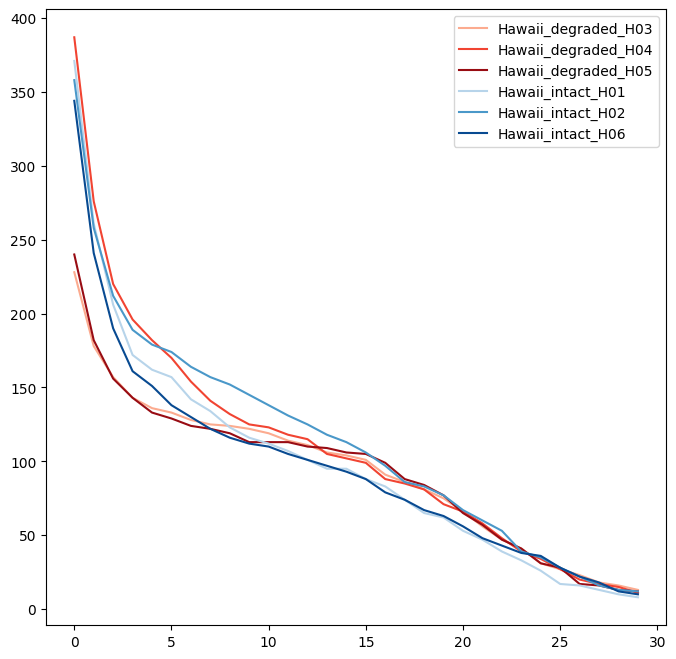

In [13]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Hawaii" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps)


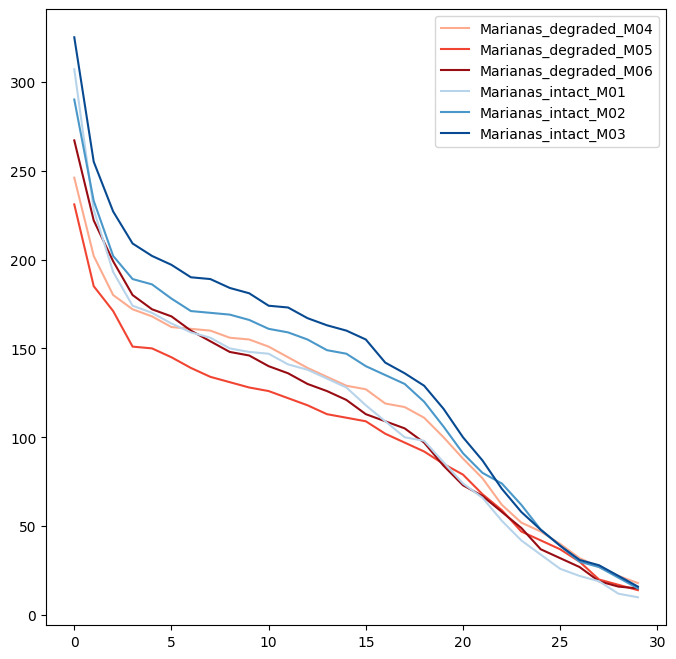

In [307]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Marianas" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps)


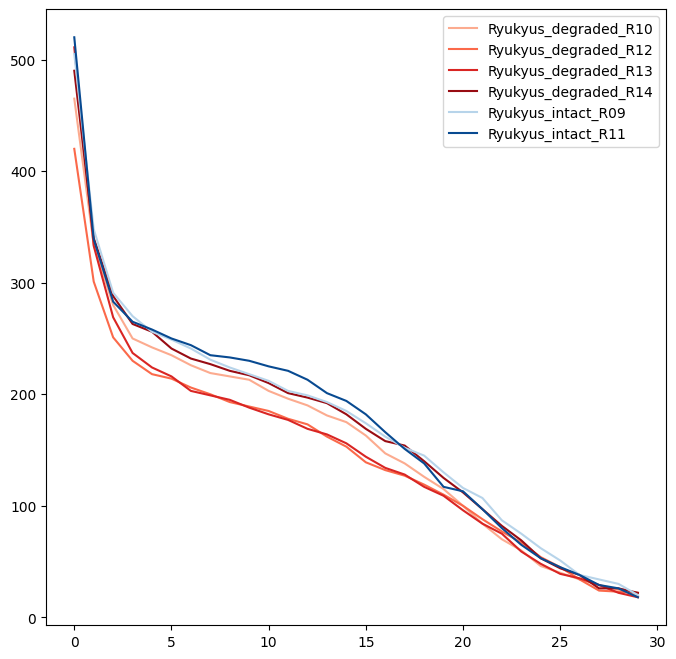

In [308]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Ryukyus" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps)


# Plot pi values

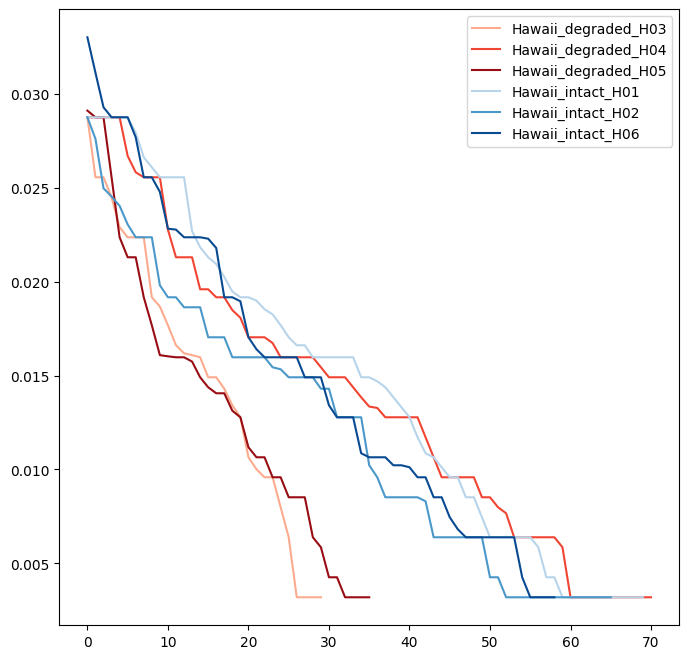

In [14]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Hawaii" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps, plot_pis=True)


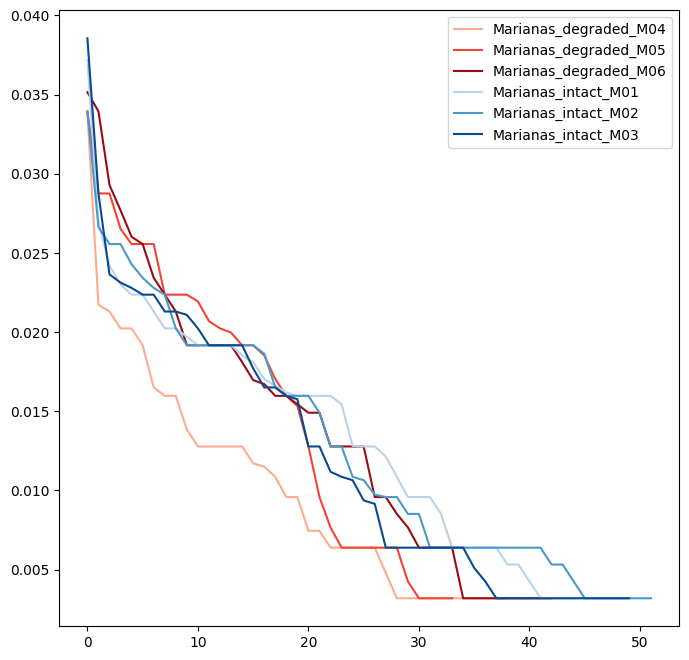

In [305]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Marianas" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps, plot_pis=True)


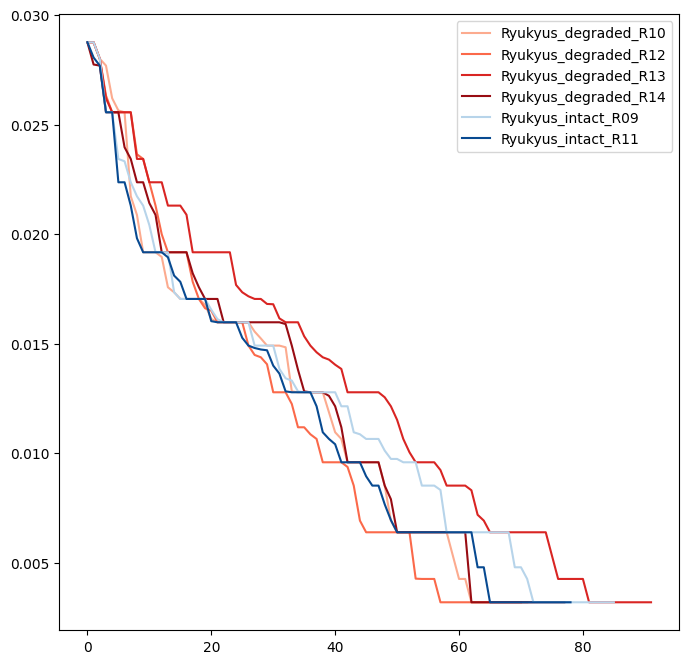

In [304]:
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}
_ = BCI.plot_multi([bci for bci in bcis.values() if "Ryukyus" in bci.samp],
                   log=False, normalize=False, keyed_cmaps=keyed_cmaps, plot_pis=True)


## All combined pis

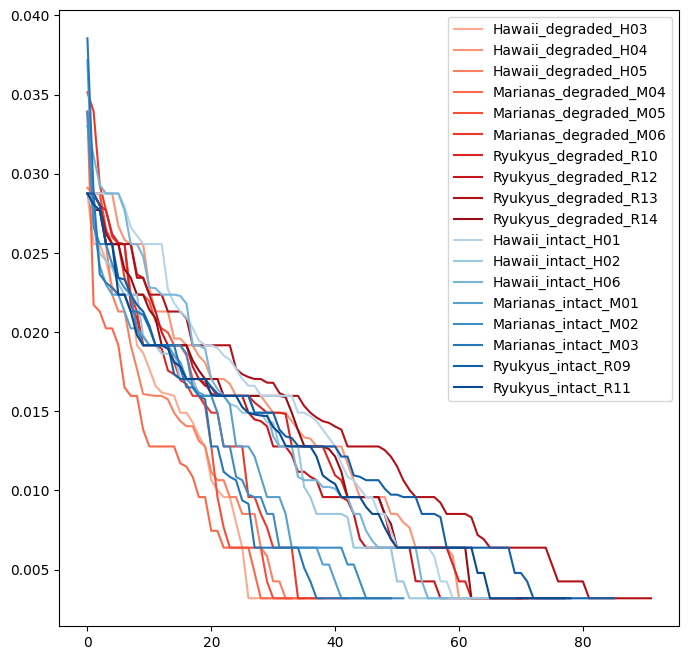

In [303]:
# Plot grouping by degraded/intact habitat
keyed_cmaps = {"degraded":"Reds",
              "intact":"Blues"}

sort_order = sorted([x.samp for x in bcis.values()], key=lambda x: x.split("_")[1])
_ = BCI.plot_multi([bcis[x] for x in sort_order], keyed_cmaps=keyed_cmaps,
                   log=False, normalize=False, plot_pis=True)

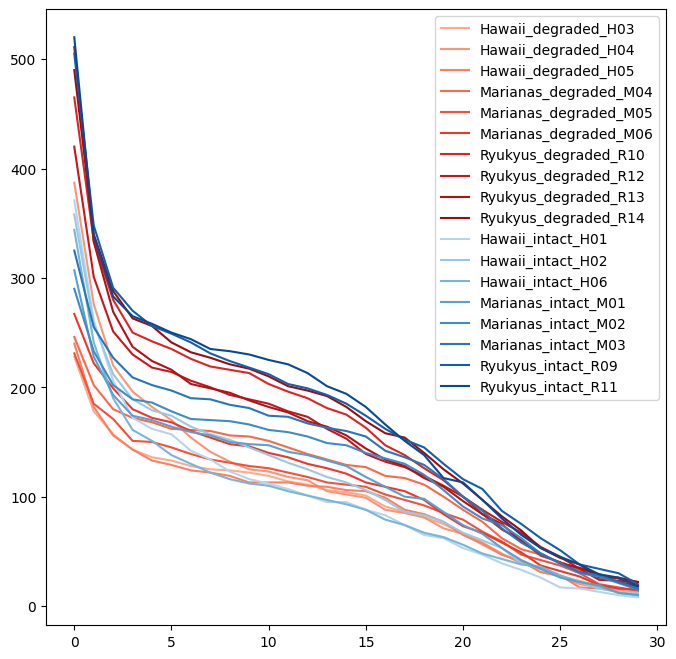

In [314]:
sort_order = sorted([x.samp for x in bcis.values()], key=lambda x: x.split("_")[1])
_ = BCI.plot_multi([bcis[x] for x in sort_order], keyed_cmaps=keyed_cmaps,
                   log=False, normalize=False)

# This is all dev for auto-97% cluster nucleotide diversity calculations

Feel free to delete because it's in the BCI tool now.

In [224]:
def _align_97_OTUs(bci):
    clusts = pd.read_csv(bci.tmpdir+f"/{s}-0.970.utmp", sep="\t", header=None, usecols=[0,1], index_col=1)
    otus = set(clusts.index)
    tmp_fastadir = bci.tmpdir+"/OTU-0.97_fastas"
    if not os.path.exists(tmp_fastadir):
        os.mkdir(tmp_fastadir)

    for otu in otus:
        zids = np.append(clusts.loc[otu].values, otu)
        seqs = seq_df.loc[zids].values
        with open(f"{tmp_fastadir}/{otu}.fasta", 'w') as outfile:
            for idx, seq in enumerate(seqs):
                outfile.write(f">{otu}_{idx}\n{seq}\n")

    print("Aligning")
    for fa in glob.glob(f"{tmp_fastadir}/*.fasta"):
        outfile = f"{fa}.aln"
        !muscle -align $fa -output $outfile -quiet -threads 2

    # Gather all aligned fastas into one file
    aligned = f"{tmp_fastadir}/combined-aligned-0.97.fasta"
    with open(aligned, 'w') as outfile:
        for fa in glob.glob(f"{tmp_fastadir}/*.aln"):
            dat = open(fa).read().split()
            for line in dat:
                if ">" in line:
                    outfile.write(f"\n{line}\n")
                else:
                    outfile.write(line)
    # Remove the leading newline. This is dumb, but it works
    dat = open(aligned).readlines()
    with open(aligned, 'w') as outfile:
        outfile.write("".join(dat[1:]).strip())

    bci.data = aligned
    bci.run()
_align_97_OTUs(bcis["Ryukyus_intact_R09"])

Aligning


In [ ]:
bcis["Ryukyus_intact_R09"].pis

In [215]:
s = "Ryukyus_intact_R09"
bci = bcis[s]
clusts = pd.read_csv(bci.tmpdir+f"/{s}-0.970.utmp", sep="\t", header=None, usecols=[0,1], index_col=1)
otus = set(clusts.index)
tmp_fastadir = bci.tmpdir+"/OTU-0.97_fastas"
if not os.path.exists(tmp_fastadir):
    os.mkdir(tmp_fastadir)

for otu in otus:
    print(otu)
    zids = np.append(clusts.loc[otu].values, otu)
    seqs = seq_df.loc[zids].values
    with open(f"{tmp_fastadir}/{otu}.fasta", 'w') as outfile:
        for idx, seq in enumerate(seqs):
            outfile.write(f">{otu}_{idx}\n{seq}\n")

zotu902_otu636
zotu487_otu379
zotu2111_otu1334
zotu4088_otu2437
zotu1159_otu791
zotu1954_otu1252
zotu4705_otu2638
zotu2193_otu1381
zotu566_otu428
zotu388_otu309
zotu27_otu27
zotu588_otu445
zotu1350_otu913
zotu270_otu219
zotu1617_otu1066
zotu233_otu190
zotu520_otu400
zotu1216_otu822
zotu227_otu179
zotu1833_otu1186
zotu5799_otu3375
zotu1102_otu756
zotu1611_otu1061
zotu2706_otu1678
zotu1887_otu1214
zotu1490_otu993
zotu34_otu34
zotu527_otu405
zotu638_otu480
zotu362_otu294
zotu921_otu648
zotu4406_otu2600
zotu4691_otu2769
zotu461_otu359
zotu515_otu397
zotu1738_otu1134
zotu77_otu70
zotu11_otu11
zotu1289_otu876
zotu242_otu196
zotu32_otu32
zotu3219_otu1973
zotu1332_otu904
zotu710_otu525
zotu680_otu504
zotu2492_otu1546
zotu1664_otu1090
zotu4509_otu2667
zotu266_otu216
zotu2812_otu1734
zotu86_otu79
zotu111_otu98
zotu4248_otu2518
zotu138_otu117
zotu1625_otu1071
zotu539_otu411
zotu4506_otu2665
zotu525_otu403
zotu84_otu77
zotu445_otu346
zotu1674_otu1097
zotu4417_otu2607
zotu1721_otu936
zotu4170_otu24

In [216]:
for fa in glob.glob(f"{tmp_fastadir}/*.fasta"):
    outfile = f"{fa}.aln"
    !muscle -align $fa -output $outfile -quiet -threads 2

In [217]:
# Gather all aligned fastas into one file
aligned = f"{tmp_fastadir}/combined-aligned-0.97.fasta"
with open(aligned, 'w') as outfile:
    for fa in glob.glob(f"{tmp_fastadir}/*.aln"):
        dat = open(fa).read().split()
        for line in dat:
            if ">" in line:
                outfile.write(f"\n{line}\n")
            else:
                outfile.write(line)
# Remove the leading newline. This is dumb, but it works
dat = open(aligned).readlines()
with open(aligned, 'w') as outfile:
    outfile.write("".join(dat[1:]).strip())

In [218]:
bci = BCI.BCI(aligned)
#bci.nucleotide_diversity()
with open(bci.data) as infile:
    #Drop the trailing newline
    dat = infile.read().split("\n")
# Simulated data species ids are of the form >r0_x
bci.pis = {x:0 for x in set([x.rsplit("_", 1)[0][1:] for x in dat[::2]])}
tmp_seq_df = pd.DataFrame(dat[1::2], index=[x.rsplit("_", 1)[0][1:] for x in dat[::2]], columns=["seqs"])
for spid in bci.pis.keys():
    bci.pis[spid] = bci._nucleotide_diversity(tmp_seq_df.loc[spid]["seqs"])
sorted(bci.pis.values(), reverse=True)
bci.pis

{'zotu902_otu636': 0.012779552715654952,
 'zotu487_otu379': 0.006389776357827476,
 'zotu2111_otu1334': 0.006389776357827476,
 'zotu4088_otu2437': 0.012779552715654952,
 'zotu1159_otu791': 0.023322683706070282,
 'zotu1954_otu1252': 0.00973680206907044,
 'zotu4705_otu2638': 0.025559105431309903,
 'zotu2193_otu1381': 0.017039403620873268,
 'zotu566_otu428': 0.02875399361022364,
 'zotu388_otu309': 0.01490947816826411,
 'zotu27_otu27': 0.003194888178913738,
 'zotu588_otu445': 0.02875399361022364,
 'zotu1350_otu913': 0.008519701810436634,
 'zotu270_otu219': 0.012140575079872205,
 'zotu1617_otu1066': 0.004792332268370607,
 'zotu233_otu190': 0.022364217252396165,
 'zotu520_otu400': 0.010649627263045792,
 'zotu1216_otu822': 0.01490947816826411,
 'zotu227_otu179': 0.017039403620873268,
 'zotu1833_otu1186': 0.01277955271565495,
 'zotu5799_otu3375': 0.023429179978700747,
 'zotu1102_otu756': 0.006389776357827476,
 'zotu2706_otu1678': 0.017039403620873268,
 'zotu1611_otu1061': 0.01611643592474264,
 

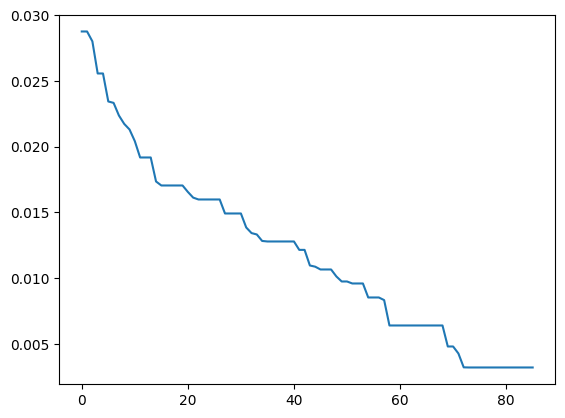

In [219]:
plt.plot(sorted(bci.pis.values(), reverse=True))

In [319]:
metadata[metadata["site"] == "H04"]

,archipelago,forest_type,site,transect,season,side,collection_method,marker,plate_well,sample_UID,zotu1_otu1,zotu714_otu1,zotu1367_otu1,zotu1785_otu1,zotu3468_otu1,zotu3885_otu1,zotu7361_otu1,zotu2_otu2,zotu3162_otu2,zotu4054_otu2,zotu9012_otu2,zotu3_otu3,zotu4_otu4,zotu5_otu5,zotu6_otu6,zotu7_otu7,zotu58_otu7,zotu107_otu7,zotu488_otu7,zotu766_otu7,zotu1115_otu7,zotu1497_otu7,zotu1509_otu7,zotu1672_otu7,zotu2524_otu7,zotu2574_otu7,zotu2664_otu7,zotu3840_otu7,zotu4565_otu7,zotu4876_otu7,zotu5837_otu7,zotu6198_otu7,zotu6850_otu7,zotu8518_otu7,zotu8_otu8,zotu1042_otu8,zotu2214_otu8,zotu2643_otu8,zotu2935_otu8,zotu5513_otu8,...,zotu7416_otu4248,zotu7429_otu4256,zotu7434_otu4258,zotu7456_otu4269,zotu7461_otu4272,zotu7479_otu4284,zotu2931_otu4286,zotu5011_otu4286,zotu7481_otu4286,zotu7482_otu4287,zotu7485_otu4288,zotu7489_otu4290,zotu7497_otu4295,zotu7498_otu4296,zotu7572_otu4344,zotu7573_otu4345,zotu1731_otu4349,zotu7597_otu4356,zotu7607_otu4361,zotu7635_otu4376,zotu7639_otu4378,zotu7640_otu4379,zotu7652_otu4388,zotu7654_otu4389,zotu7660_otu4392,zotu7674_otu4399,zotu7679_otu4402,zotu7683_otu4404,zotu7687_otu4407,zotu7692_otu4411,zotu7705_otu4419,zotu7707_otu4420,zotu7722_otu4430,zotu6473_otu4431,zotu7648_otu4431,zotu7723_otu4431,zotu8584_otu4431,zotu7745_otu4445,zotu6684_otu4449,zotu7750_otu4449,zotu767_otu4454,zotu7764_otu4458,zotu7771_otu4462,zotu7772_otu4463,zotu7779_otu4466,zotu7787_otu4470,zotu7788_otu4471,zotu8761_otu4471,zotu7826_otu4483,zotu7831_otu4486
154,Hawaii,degraded,H04,H04A,NaN,windward,beating,HCO,KM1_11E,H04AV06,882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
156,Hawaii,degraded,H04,H04A,NaN,windward,beating,HCO,KM1_11F,H04AV07,1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158,Hawaii,degraded,H04,H04B,NaN,windward,beating,HCO,KM1_11G,H04BV06,1532,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160,Hawaii,degraded,H04,H04B,NaN,windward,beating,HCO,KM1_11H,H04BV07,818,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
328,Hawaii,degraded,H04,H04A,NaN,windward,beating,HCO,KM2_11E,H04AV08,787,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
330,Hawaii,degraded,H04,H04A,NaN,windward,beating,HCO,KM2_11F,H04AV09,1231,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
332,Hawaii,degraded,H04,H04A,NaN,windward,beating,HCO,KM2_11G,H04AV10,1143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
334,Hawaii,degraded,H04,H04B,NaN,windward,beating,HCO,KM2_11H,H04BV08,1080,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
512,Hawaii,degraded,H04,H04B,NaN,windward,beating,HCO,KM3_11E,H04BV09,1901,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
514,Hawaii,degraded,H04,H04B,NaN,windward,beating,HCO,KM3_11F,H04BV10,1941,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,